<a href="https://colab.research.google.com/github/MB-2-jpg/Image-processing/blob/main/Kvasir_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [2]:
pip install albumentations


In [3]:
pip install lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 43.4 MB/s eta 0:00:00


In [4]:
pip install matplotlib opencv-python

In [5]:
!wget https://datasets.simula.no/downloads/kvasir-seg.zip
!unzip kvasir-seg.zip -d data/

--2025-05-25 16:26:36--  https://datasets.simula.no/downloads/kvasir-seg.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46227172 (44M) [application/zip]
Saving to: ‘kvasir-seg.zip.1’

kvasir-seg.zip.1    100%[===================>]  44.08M  20.8MB/s    in 2.1s    

2025-05-25 16:26:38 (20.8 MB/s) - ‘kvasir-seg.zip.1’ saved [46227172/46227172]

Archive:  kvasir-seg.zip
replace data/Kvasir-SEG/kavsir_bboxes.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/Kvasir-SEG/kavsir_bboxes.json  
replace data/Kvasir-SEG/images/ck2bxiswtxuw80838qkisqjwz.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/Kvasir-SEG/images/ck2bxiswtxuw80838qkisqjwz.jpg  
replace data/Kvasir-SEG/images/ck2bxknhjvs1x0794iogrq49k.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/Kvasir-SEG/images/ck2bxknhjvs1x0794iogrq49

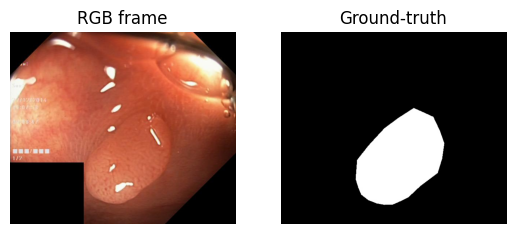

In [6]:
import cv2, matplotlib.pyplot as plt
img  = cv2.cvtColor(cv2.imread('/content/data/Kvasir-SEG/images/cju5ft6mcd5q40987rhjgbrr6.jpg'), cv2.COLOR_BGR2RGB)
mask = cv2.imread('/content/data/Kvasir-SEG/masks/cju5ft6mcd5q40987rhjgbrr6.jpg', 0)  # grayscale

plt.subplot(1,2,1); plt.imshow(img);  plt.title('RGB frame');  plt.axis('off')
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.title('Ground-truth'); plt.axis('off')
plt.show()



TypeError: Image data of dtype object cannot be converted to float

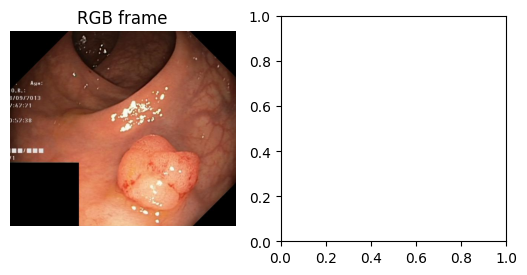

In [16]:
import cv2, matplotlib.pyplot as plt
img  = cv2.cvtColor(cv2.imread('/content/data/Kvasir-SEG/images/cju5huurrecm70801y680y13m.jpg'), cv2.COLOR_BGR2RGB)
mask = cv2.imread('data/Kvasir-SEG/masks/42.jpg', 0)  # grayscale

plt.subplot(1,2,1); plt.imshow(img);  plt.title('RGB frame');  plt.axis('off')
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.title('Ground-truth'); plt.axis('off')
plt.show()


/content/data/Kvasir-SEG/images/cju15mhjczc8z0801kit5c6di.jpg
/content/data/Kvasir-SEG/masks/cju15mhjczc8z0801kit5c6di.jpg


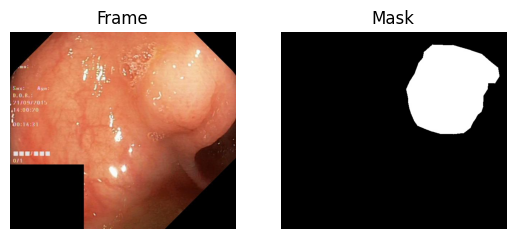

In [28]:
import cv2, matplotlib.pyplot as plt, random, numpy as np
img_path  = random.choice(list(imgs_dir.glob('*.jpg')))
mask_path = root/'Kvasir-SEG'/'masks'/img_path.with_suffix('.jpg').name
print(img_path)
print(mask_path)
img  = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1); plt.imshow(img);               plt.axis('off'); plt.title('Frame')
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.axis('off'); plt.title('Mask')
plt.show()


In [42]:
from pathlib import Path
from torch.utils.data import Dataset
import cv2

class KvasirSeg(Dataset):
    def __init__(self, root_dir, transform=None):
        root_dir ="/content/data/Kvasir-SEG"

        self.images_dir = Path(root_dir)/'images'
        self.masks_dir  = Path(root_dir)/'masks'
        # pick up .jpg (frames) and also .jpg (masks)
        self.img_files  = sorted(self.images_dir.glob('*.jp*g'))
        self.mask_files = sorted(self.masks_dir .glob('*.jp*g'))

        assert len(self.img_files) > 0, f"No images found in {self.images_dir}"
        assert len(self.img_files) == len(self.mask_files), (
            f"Image/mask count mismatch: {len(self.img_files)} vs {len(self.mask_files)}"
        )
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path  = self.img_files[idx]
        mask_path = self.masks_dir / img_path.name   # same basename & extension

        img  = cv2.imread(str(img_path))
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        assert img  is not None, f"Cannot read image {img_path}"
        assert mask is not None, f"Cannot read mask  {mask_path}"

        img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        # normalize to [0,1] and add channel dims
        img  = img.float()  / 255.0
        mask = mask.unsqueeze(0).float() / 255.0

        return img, mask



In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_tf = A.Compose([
    # RandomResizedCrop in v2 wants a single `size` tuple
    A.RandomResizedCrop(
        size=(256, 256),        # **required**: (height, width)
        scale=(0.8, 1.0),       # zoom range
        ratio=(0.75, 1.3333),   # aspect-ratio limits (default)
        interpolation=1,        # cv2.INTER_LINEAR
    ),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ElasticTransform(
        alpha=40, sigma=4, alpha_affine=4, p=0.3
    ),
    A.RandomBrightnessContrast(p=0.3),
    ToTensorV2()
])

val_tf = A.Compose([
    # Resize in v2 uses named height/width
    A.Resize(
        height=256, width=256,
        interpolation=1,           # linear for image
        mask_interpolation=0       # nearest for masks
    ),
    ToTensorV2()
])



/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-10-4f65c52f44e8>:14: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(


In [11]:
import torch, torch.nn as nn
class DoubleConv(nn.Sequential):
    def __init__(self, in_c, out_c):
        super().__init__(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU(inplace=True)
        )
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=1):
        super().__init__()
        self.enc1 = DoubleConv(c_in, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bott = DoubleConv(512, 1024)
        self.up4  = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3  = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2  = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1  = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, c_out, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b  = self.bott(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4], 1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], 1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], 1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], 1))
        return torch.sigmoid(self.outc(d1))


In [27]:
def dice_coef(pred, target, eps=1e-7):
    pred, target = pred.view(-1), target.view(-1)
    inter = (pred*target).sum()
    return (2*inter + eps) / (pred.sum() + target.sum() + eps)

class DiceBCELoss(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pred, target):
        bce  = nn.functional.binary_cross_entropy(pred, target)
        dsc  = 1 - dice_coef(pred>0.5, target)
        return bce + dsc


In [51]:
from torch.utils.data import random_split, DataLoader
import torch
full_ds = KvasirSeg(DATASET_DIR, transform=train_tf)
print("Full dataset size:", len(full_ds))

# split
train_size = int(0.8 * len(full_ds))
val_size   = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size],
                                generator=torch.Generator().manual_seed(42))
val_ds.dataset.transform = val_tf

# loaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# device + model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = UNet().to(device)

# optimizer
opt = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-2  # roughly what AdamW would have done
)

crit = DiceBCELoss()


Full dataset size: 1000


In [ ]:
import torch

device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model      = model.to(device)      # your UNet instance
num_epochs = 30

for epoch in range(1, num_epochs+1):
    # ─── Training ──────────────────────────────────────────────────────────
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        opt.zero_grad()
        preds = model(x_batch)             # forward pass
        loss  = crit(preds, y_batch)      # combined Dice+BCE loss
        loss.backward()                   # back-prop
        opt.step()                        # update weights

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # ─── Validation ───────────────────────────────────────────────────────
    model.eval()
    dice_scores = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(x_batch)
            # binarize at 0.5 for Dice
            preds_bin = (preds > 0.5).float()
            dice_scores.append(dice_coef(preds_bin, y_batch).item())

    val_dice = sum(dice_scores) / len(dice_scores)

    # ─── Logging ──────────────────────────────────────────────────────────
    print(f"Epoch {epoch:02d}/{num_epochs:02d}  "
          f"Train Loss: {train_loss:.4f}  "
          f"Val Dice: {val_dice:.4f}")


Epoch 01/30  Train Loss: 1.4021  Val Dice: 0.0000


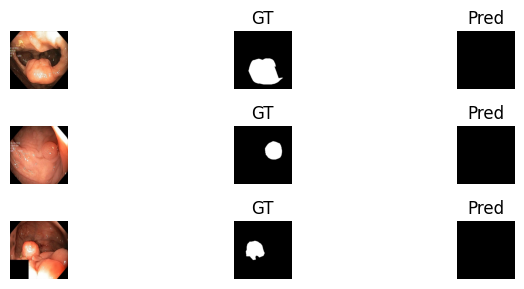

In [45]:
model.eval(); x,y = next(iter(val_loader))
with torch.no_grad(): p = model(x.to(device)).cpu()
plt.figure(figsize=(8,3))
for i in range(3):
    plt.subplot(3,3,3*i+1); plt.imshow(x[i].permute(1,2,0)); plt.axis('off')
    plt.subplot(3,3,3*i+2); plt.imshow(y[i,0], cmap='gray'); plt.title('GT'); plt.axis('off')
    plt.subplot(3,3,3*i+3); plt.imshow((p[i,0]>0.5), cmap='gray'); plt.title('Pred'); plt.axis('off')
plt.tight_layout(); plt.show()


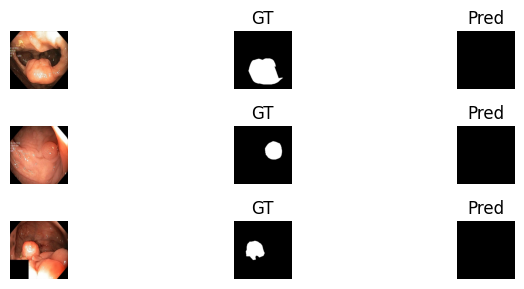

In [46]:
model.eval(); x,y = next(iter(val_loader))
with torch.no_grad(): p = model(x.to(device)).cpu()
plt.figure(figsize=(8,3))
for i in range(3):
    plt.subplot(3,3,3*i+1); plt.imshow(x[i].permute(1,2,0)); plt.axis('off')
    plt.subplot(3,3,3*i+2); plt.imshow(y[i,0], cmap='gray'); plt.title('GT'); plt.axis('off')
    plt.subplot(3,3,3*i+3); plt.imshow((p[i,0]>0.5), cmap='gray'); plt.title('Pred'); plt.axis('off')
plt.tight_layout(); plt.show()


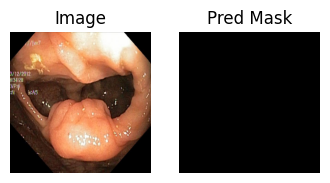

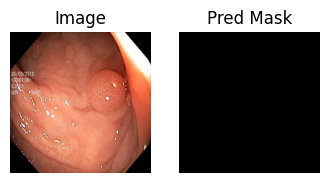

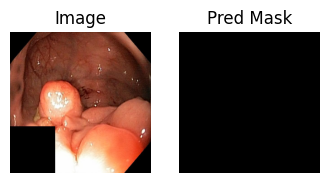

In [50]:
import torch
import matplotlib.pyplot as plt

model.eval()                                   # set eval mode
with torch.no_grad():                          # disable grads
    x_batch, y_batch = next(iter(val_loader))  # get a batch
    x_gpu = x_batch.to(device)
    preds = model(x_gpu)                       # shape: (B,1,H,W)
    probs = preds[:, 0].cpu().detach().numpy() # now (B,H,W) numpy array

# display first 3 examples
for i in range(3):
    plt.figure(figsize=(4,4))
    plt.subplot(1,2,1)
    plt.imshow(x_batch[i].permute(1,2,0))       # original image
    plt.axis('off'); plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(probs[i] > 0.5, cmap='gray')    # thresholded mask
    plt.axis('off'); plt.title('Pred Mask')
    plt.show()


In [24]:
from pathlib import Path
root = Path('/content/data')

# Search up to two levels deep for a mask file
mask_sample = next(root.rglob('*/masks/*.jpg'), None)
print("Mask sample found at:", mask_sample)



Mask sample found at: /content/data/Kvasir-SEG/masks/cju2r91dg2k090801bh0xzbxk.jpg


In [23]:
DATASET_DIR = Path('/content/data/kvasir-seg/Kvasir-SEG')


In [22]:
# List the first 30 lines of /content/data to see what's inside
!ls -R /content/data | head -n 30



/content/data:
Kvasir-SEG

/content/data/Kvasir-SEG:
images
kavsir_bboxes.json
masks

/content/data/Kvasir-SEG/images:
cju0qkwl35piu0993l0dewei2.jpg
cju0qoxqj9q6s0835b43399p4.jpg
cju0qx73cjw570799j4n5cjze.jpg
cju0roawvklrq0799vmjorwfv.jpg
cju0rx1idathl0835detmsp84.jpg
cju0s2a9ekvms080138tjjpxr.jpg
cju0s690hkp960855tjuaqvv0.jpg
cju0sr5ghl0nd08789uzf1raf.jpg
cju0sxqiclckk08551ycbwhno.jpg
cju0t4oil7vzk099370nun5h9.jpg
cju0tl3uz8blh0993wxvn7ly3.jpg
cju0u2g7pmnux0801vkk47ivj.jpg
cju0u82z3cuma0835wlxrnrjv.jpg
cju0ue769mxii08019zqgdbxn.jpg
cju0vtox5ain6099360pu62rp.jpg
cju13cgqmnhwn0988yrainhcp.jpg
cju13fwthn9mq0835gacxgy01.jpg
cju13hp5rnbjx0835bf0jowgx.jpg
cju14g8o4xui30878gkgbrvqj.jpg
cju14hjh2ob2o0835ouz3r5aa.jpg
cju14pxbaoksp0835qzorx6g6.jpg


In [21]:
from pathlib import Path
root       = Path('/content/data')
imgs_dir   = root / 'Kvasir-SEG' / 'images'
masks_dir  = root / 'Kvasir-SEG' / 'masks'

print("Images dir exists :", imgs_dir.exists())
print("Masks  dir exists :", masks_dir.exists())
print("PNG images found  :", len(list(imgs_dir.glob('*.jpg'))))
print("PNG masks  found  :", len(list(masks_dir.glob('*.jpg'))))


Images dir exists : True
Masks  dir exists : True
PNG images found  : 1000
PNG masks  found  : 1000


In [20]:
# re-run the count
from pathlib import Path
root = Path('/content/data')
imgs_dir = root/'Kvasir-SEG'/'images'
print('JPEG images found :', len(list(imgs_dir.glob('*.jpg'))))
# expected ≈ 1000



JPEG images found : 1000


In [19]:
from pathlib import Path
root = Path('data')                           # adjust if you un-zipped elsewhere
print(root.resolve())

/content/data
